In [105]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import re

In [106]:
arg_component_balance=False
arg_add_new_dataset=False
arg_add_transformer=True

In [107]:
result_path = './meta/results'
datasets = ['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2', 'ili', 'weather', 'ECL', 'Exchange', 'traffic']
if arg_add_new_dataset:
    datasets.extend(['covid-19', 'fred-md'])
file_list = [f'{dataset}-component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}.npz' for dataset in datasets]

baselines = [
 'iTransformer',
 'MambaSimple',
 'PatchTST',
 'TimeMixer',
 'Koopa',
 'SegRNN',
 'DLinear',
 'FEDformer',
 'Crossformer',
 'Informer',
 'PAttn',
 'ETSformer',
 'TimeXer',
 'LightTS',
 'Nonstationary',
 'TiDE',
 'Pyraformer',
 'MICN',
 'Transformer',
 'FiLM',
 'TimesNet',
 'TSMixer',
 'Autoformer',
 'Reformer',
 'DUET']
print(len(file_list))

9


In [108]:
os.listdir('./results_long_term_forecasting/results/ECL')

['LTF_Pyraformer_custom_ftM_sl96_ll48_pl720_dm512_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_epochs10_lfMSE_lr0.0001_lrstype1_0',
 'LTF_Pyraformer_custom_ftM_sl96_ll48_pl192_dm512_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_epochs10_lfMSE_lr0.0001_lrstype1_0',
 'LTF_DLinear_custom_ftM_sl96_ll48_pl720_dm512_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_epochs10_lfMSE_lr0.0001_lrstype1_0',
 'LTF_Crossformer_custom_ftM_sl96_ll48_pl336_dm512_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_epochs10_lfMSE_lr0.0001_lrstype1_0',
 'LTF_MICN_custom_ftM_sl96_ll96_pl192_dm512_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_epochs10_lfMSE_lr0.0001_lrstype1_0',
 'LTF_Koopa_custom_ftM_sl1440_ll48_pl720_dm512_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_epochs10_lfMSE_lr0.0001_lrstype1_0',
 'LTF_FiLM_custom_ftM_sl192_ll48_pl192_dm512_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_epochs10_lfMSE_lr0.0001_lrstype1_0',
 'LTF_SegRNN_custom_ftM_sl96_ll48_pl192_dm512_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_epochs10_lfMSE_lr0.0001_lrstype1_0',
 'LTF_DLinear_custom

In [109]:
# sota performance
def search_sota_performance(dataset, pred_lens=[96],
                            path_old='./results', 
                            path='./results_long_term_forecasting/results'):
    result_dict = {}
    for pred_len in pred_lens:
        model_list_old = os.listdir(path_old)
        model_list_old = [_ for _ in model_list_old if f'pl{pred_len}' in _ and dataset in _]

        try:
            model_list_new = os.listdir(os.path.join(path, dataset))
            model_list_new = [_ for _ in model_list_new if f'pl{pred_len}' in _]
        except:
            model_list_new = []
        model_list = model_list_old + model_list_new

        result_dict[pred_len] = {}
        for model in model_list:
            try:
                result = np.load(os.path.join(path_old, model, 'metrics.npy'), allow_pickle=True)
            except:
                result = np.load(os.path.join(path, dataset, model, 'metrics.npy'), allow_pickle=True)
            result_dict[pred_len][model] = result[1]

    df = pd.DataFrame.from_dict(result_dict[pred_lens[0]], orient='index')
    df.columns = ['mse']
    df = df.sort_values(by='mse')
    df.index = [_.split('_')[6] for _ in df.index]

    return df

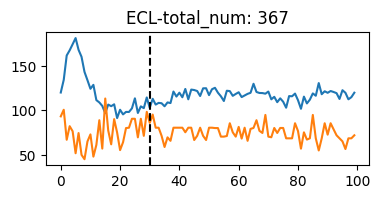

In [110]:
fig = plt.figure(figsize=(15, 9))
for i, file in enumerate(file_list):
    try:
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        # print(perf_epoch.files)

        fig.add_subplot(4, 3, i+1)
        for _ in perf_epoch.files:
            if _ in ['pred_ranks_for_true_topk_epoch', 'true_ranks_for_pred_topk_epoch']:
                plt.plot(perf_epoch[_], label=_)
            elif _ == 'total_num':
                plt.title(f'{file.replace(".npz", "").split("-")[0]}-total_num: {perf_epoch[_]}')
            elif _ == 'best_epoch':
                plt.axvline(perf_epoch['best_epoch'].item(), color='black', linestyle='--')
            else:
                pass 

        if i==0: plt.legend()
    except:
        continue

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './meta/results/ETTh1-component_balance_False-add_new_dataset_False-add_transformer_True.npz'

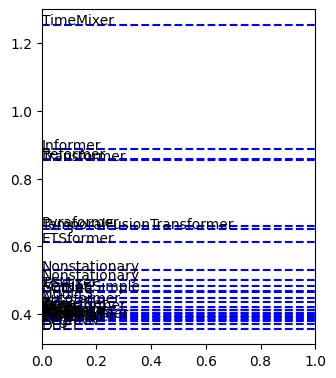

In [111]:
fig = plt.figure(figsize=(12, 20))
for i, file in enumerate(file_list):
    try:
        dataset = file[:re.search('-component', file).start()]
        if dataset in ['ili', 'covid-19', 'fred-md']:
            df = search_sota_performance(dataset, pred_lens=[24])
        else:
            df = search_sota_performance(dataset)
        # except:
        #     continue
        fig.add_subplot(4, 3, i+1)
        for model, metric in df.iterrows():
            plt.axhline(y=metric.item(), color='blue', linestyle='--')
            plt.text(0, metric.item(), model, color='black')

        # 添加图例和标题
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        top1_perf_epoch = perf_epoch['top1_perf_epoch']
        plt.plot(top1_perf_epoch, color='orange', label='TSGym')

        plt.legend()
        plt.title(f'TSGym vs SOTA, Dataset: {dataset}')
    except:
        continue

plt.show()

In [95]:
# TSGym vs best sota
dfs = []
ranks = {k: [] for k in baselines}
ranks['TSGym'] = []
for i, file in enumerate(file_list):
    # dataset = file.split('-')[0]
    dataset = file[:re.search('-component', file).start()]

    if dataset in ['ili', 'covid-19', 'fred-md']:
        df = search_sota_performance(dataset, pred_lens=[24])
    else:
        df = search_sota_performance(dataset)

    # 添加图例和标题
    perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
    top1_perf_epoch = perf_epoch['top1_perf_epoch']


    df.loc['TSGym'] = top1_perf_epoch[perf_epoch['best_epoch'].item()]
    df = df.sort_values(by='mse')
    df = df.reset_index()
    df.columns = ['model', dataset]
    # todo: 有重复, 并且跑出来结果还不同
    df = df.drop_duplicates(subset='model', keep='first')
    for baseline in baselines:
        if len(np.where(df['model'] == baseline)[0]) > 0:
            ranks[baseline].append((np.where(df['model'] == baseline)[0] + 1).item())
    ranks['TSGym'].append((np.where(df['model'] == 'TSGym')[0] + 1).item())
    dfs.append(df)

dfs = pd.concat(dfs, axis=1)
dfs

,model,ETTh1,model,ETTh2,model,ETTm1,model,ETTm2,model,ili,model,weather,model,ECL,model,Exchange,model,traffic
0,DUET,0.355946,TSGym,0.281048,DUET,0.292933,DUET,0.168728,TemporalFusionTransformer,1.860526,TSGym,0.153916,TSGym,0.139135,DUET,0.079999,DUET,0.359848
1,SegRNN,0.370867,SegRNN,0.282564,TSGym,0.304596,TimeXer,0.170625,PatchTST,2.168191,DUET,0.154809,MICN,0.170311,TimeMixer,0.083601,TSGym,0.397309
2,PatchTST,0.380158,TimeXer,0.287365,MICN,0.320593,SegRNN,0.172851,TimesNet,2.174988,TimeXer,0.158659,Nonstationary,0.170392,PAttn,0.085506,PatchTST,0.471588
3,TimeMixer,0.381575,DUET,0.289897,PAttn,0.321724,TSGym,0.173672,Koopa,2.209361,TimeMixer,0.162554,TimesNet,0.172471,PatchTST,0.086641,PAttn,0.498926
4,TimeXer,0.383762,TimeMixer,0.291129,FiLM,0.324987,TimeMixer,0.174330,PAttn,2.227032,SegRNN,0.165622,TemporalFusionTransformer,0.177838,TimeXer,0.087320,MICN,0.516740
5,TiDE,0.384989,PatchTST,0.295004,TimesNet,0.325995,NaN,NaN,TSGym,2.318571,Koopa,0.167305,SCINet,0.180232,iTransformer,0.088296,FreTS,0.564330
7,iTransformer,0.391148,PAttn,0.296974,TimeXer,0.331773,PAttn,0.179924,Nonstationary,2.537160,TimesNet,0.169092,FreTS,0.189423,SegRNN,0.091455,FEDformer,0.586253
8,PAttn,0.391195,iTransformer,0.300953,FreTS,0.339759,PatchTST,0.181935,TimeXer,2.869135,LightTS,0.170235,PatchTST,0.196937,TiDE,0.092930,TimesNet,0.589141
9,TSGym,0.392057,Koopa,0.308469,Crossformer,0.340736,SCINet,0.182853,DUET,2.999598,Crossformer,0.171791,DLinear,0.210297,NaN,NaN,Nonstationary,0.604313
10,DLinear,0.395788,FiLM,0.316959,NaN,NaN,iTransformer,0.183662,FEDformer,3.153684,iTransformer,0.172495,Autoformer,0.213805,MICN,0.092951,LightTS,0.611749


In [96]:
ranks

{'iTransformer': [7, 8, 11, 10, 7, 11, 6],
 'MambaSimple': [21, 23, 26, 23, 27, 19],
 'PatchTST': [3, 6, 8, 2, 12, 9, 4, 3],
 'TimeMixer': [4, 5, 5, 23, 4, 2],
 'Koopa': [13, 9, 4, 6, 7],
 'SegRNN': [2, 2, 7, 3, 15, 5, 8],
 'DLinear': [10, 13, 13, 16, 22, 19, 10, 11, 14],
 'FEDformer': [12, 14, 16, 15, 11, 24, 20, 8],
 'Crossformer': [16, 24, 10, 25, 14, 10, 24, 21],
 'Informer': [29, 29, 24, 27, 24, 26, 27, 16],
 'PAttn': [8, 7, 4, 7, 5, 14, 7, 3, 4],
 'ETSformer': [24, 18, 21, 22, 19, 23, 15, 18],
 'TimeXer': [5, 3, 8, 2, 9, 3, 5],
 'LightTS': [19, 19, 14, 17, 29, 9, 12, 18, 11],
 'Nonstationary': [23, 21, 17, 18, 8, 13, 3, 17, 10],
 'TiDE': [6, 11, 15, 12, 26, 22, 13, 9, 17],
 'Pyraformer': [26, 26, 22, 24, 21, 21, 14, 26, 13],
 'MICN': [15, 17, 3, 11, 13, 17, 2, 10, 5],
 'Transformer': [27, 28, 19, 26, 20, 27, 25],
 'FiLM': [14, 10, 5, 6, 17, 18, 22],
 'TimesNet': [17, 12, 6, 14, 3, 8, 4, 16, 9],
 'TSMixer': [22, 25, 18, 20, 25, 15, 23],
 'Autoformer': [18, 20, 20, 21, 16, 25, 11, 

In [97]:
{k: np.mean(v) for k,v in ranks.items() if len(v) > 0}

{'iTransformer': 8.571428571428571,
 'MambaSimple': 23.166666666666668,
 'PatchTST': 5.875,
 'TimeMixer': 7.166666666666667,
 'Koopa': 7.8,
 'SegRNN': 6.0,
 'DLinear': 14.222222222222221,
 'FEDformer': 15.0,
 'Crossformer': 18.0,
 'Informer': 25.25,
 'PAttn': 6.555555555555555,
 'ETSformer': 20.0,
 'TimeXer': 5.0,
 'LightTS': 16.444444444444443,
 'Nonstationary': 14.444444444444445,
 'TiDE': 14.555555555555555,
 'Pyraformer': 21.444444444444443,
 'MICN': 10.333333333333334,
 'Transformer': 24.571428571428573,
 'FiLM': 13.142857142857142,
 'TimesNet': 9.88888888888889,
 'TSMixer': 21.142857142857142,
 'Autoformer': 18.0,
 'Reformer': 24.625,
 'DUET': 2.625,
 'TSGym': 4.333333333333333}

In [99]:
# dfs.to_excel(f'/data/coding/chaochuan/TSGym/meta/component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}.xlsx', index=False)


meta-feature的差异性

In [100]:
# meta_feature_path = '/data/coding/chaochuan/TSGym/meta_learner_cc/meta_feature_copy/meta_feature'

In [101]:
# meta_features_dict = {}
# for file in os.listdir(meta_feature_path):
#     if file.endswith('.npz'):
#         meta_feature = np.load(os.path.join(meta_feature_path, file), allow_pickle=True)
#         meta_features_dict[file.replace('.npz', '').replace('meta_feature_', '')] = meta_feature['meta_feature']

In [102]:
# meta_features = np.stack(list(meta_features_dict.values()))
# meta_features = np.clip(meta_features, -1e4, 1e4)

# # z-score
# mu = np.nanmean(meta_features, axis=0, keepdims=True)
# std = np.nanstd(meta_features, axis=0, keepdims=True)

# meta_features = (meta_features - mu) / (std + 1e-6)
# meta_features = np.nan_to_num(meta_features, nan=0.0)

In [103]:
# fig = plt.figure(figsize=(20, 20))

# for seed in range(1, 5):
#     tsne = TSNE(n_components=2, random_state=seed, perplexity=10)
#     meta_features_tsne = tsne.fit_transform(meta_features) 
#     meta_features_dict_tsne = {k: v for k, v in zip(meta_features_dict.keys(), meta_features_tsne)}
#     fig.add_subplot(2, 2, seed)
#     for k, v in meta_features_dict_tsne.items():
#         plt.scatter(v[0], v[1])
#         plt.text(v[0], v[1], k, fontsize=12)
# fig.suptitle('TSNE', fontsize=16)
# plt.show()


In [104]:
# fig = plt.figure(figsize=(20, 20))

# pca = PCA(n_components=2, random_state=42)
# meta_features_pca = pca.fit_transform(meta_features) 
# meta_features_dict_pca = {k: v for k, v in zip(meta_features_dict.keys(), meta_features_pca)}
# for k, v in meta_features_dict_pca.items():
#     plt.scatter(v[0], v[1])
#     plt.text(v[0], v[1], k, fontsize=16)
# plt.title('PCA', fontsize=16)
# plt.show()
